# Brain MRI Segmentation

This notebook contains a simplistic code for barin MRI segmentation task. 
[The dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) that is used here contains only 110 patients and is obtained from The Cancer Genome Atlas (TCGA).
Also, some parts of this code are building on top of [this notebook](https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch).

In [1]:
import os
import logging
import numpy as np
import imgaug.augmenters as iaa
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

from datasets.brain_dataset import BrainSegmentationDataset
from datasets.transforms import Augmentation, ToTensor, ToImage
from models.unet import UNet
from metrics.dice_loss import DiceLoss, dice_score
from train import train_supervised, train_eval_supervised
from evaluate import evaluate, generate_outputs
from utils.params import Params, save_dict_to_json
from utils.logger import set_logger, save_checkpoint, load_checkpoint
from utils.visualizer import save_image_mask, plot_samples

In [2]:
dataset_dir = "/pasteur/u/mottaghi/lgg-mri-segmentation/processed"
base_params_path = "experiments/base_params.json"
model_dir = "experiments/supervised_run1"
restore = True

os.makedirs(model_dir, exist_ok=True)
params_path = os.path.join(model_dir, "params.json")
if restore and os.path.exists(params_path):
    params = Params(params_path)
else:
    params = Params(base_params_path)
    params.save(params_path)
params.model_dir = model_dir
params.restore = True
params.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_logger(os.path.join(model_dir, "logs.txt"))

In [3]:
train_aug = iaa.Sequential([
    iaa.Affine(scale=(0.95, 1.05)), 
    iaa.Affine(rotate=(-15, 15)),
    iaa.Fliplr(0.5), 
])
train_transforms = Compose([Augmentation(train_aug), ToTensor()])
totensor = ToTensor()
toimage = ToImage()

### Data

In [4]:
train_dataset = BrainSegmentationDataset(dataset_dir, subset="labeled", transform=train_transforms, params=params)
val_dataset = BrainSegmentationDataset(dataset_dir, subset="validation", transform=totensor, params=params)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=params.batch_size, drop_last=False)

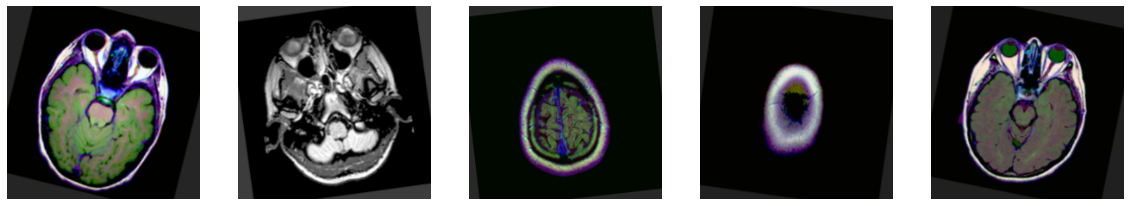

In [6]:
rand_idx = np.random.choice(len(train_dataset), 5)
samples = [toimage(train_dataset[idx]) for idx in rand_idx]
plot_samples(samples)

### Training

In [7]:
model = UNet(in_channels=3, out_channels=1)
model.to(params.device)
optimizer = torch.optim.Adam(model.parameters(), lr=params.learning_rate)
loss_fn = DiceLoss()
metrics = {'dice score': dice_score}

In [8]:
train_eval_supervised(model, optimizer, loss_fn, train_loader, val_loader, metrics, params)

Restoring parameters from experiments/supervised_run1/best.pth.tar
Epoch 52/100
100%|██████████| 24/24 [00:05<00:00,  4.79it/s, loss=0.767]
- Train metrics: dice score: 0.700 ; loss: 0.805
- Eval metrics : dice score: 0.758 ; loss: 0.730
Epoch 53/100
100%|██████████| 24/24 [00:04<00:00,  5.27it/s, loss=0.762]
- Train metrics: dice score: 0.923 ; loss: 0.694
- Eval metrics : dice score: 0.695 ; loss: 0.711
Epoch 54/100
100%|██████████| 24/24 [00:04<00:00,  5.13it/s, loss=0.746]
- Train metrics: dice score: 0.769 ; loss: 0.746
- Eval metrics : dice score: 0.747 ; loss: 0.717
Epoch 55/100
100%|██████████| 24/24 [00:04<00:00,  5.27it/s, loss=0.744]
- Train metrics: dice score: 0.846 ; loss: 0.688
- Eval metrics : dice score: 0.609 ; loss: 0.723
Epoch 56/100
100%|██████████| 24/24 [00:04<00:00,  5.32it/s, loss=0.726]
- Train metrics: dice score: 0.920 ; loss: 0.405
- Eval metrics : dice score: 0.805 ; loss: 0.710
Epoch 57/100
100%|██████████| 24/24 [00:04<00:00,  4.92it/s, loss=0.703]
- Tra

### Evaluation

In [11]:
output_list = generate_outputs(model, val_loader, params, save=True)

/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_155.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_207.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_208.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_209.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_260.png is a low contrast image
  imsave(path, image)
/sailhome/mottaghi/brain-segmentation/utils/visualizer.py:33: UserWarning: experiments/supervised_run1/output/val_295.png is a low contrast image
  imsave(path,

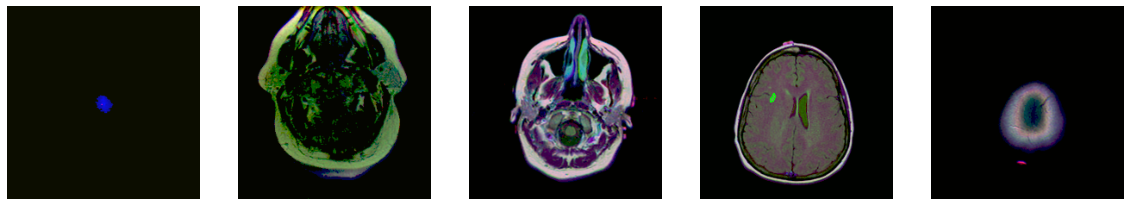

In [12]:
rand_idx = np.random.choice(len(output_list), 5)
samples = [output_list[idx] for idx in rand_idx]
plot_samples(samples)